<a href="https://colab.research.google.com/github/imanuelot/KeuanganApp/blob/main/Klasifikasi_katarak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kagglehub tensorflow

In [ ]:
import os
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [ ]:
# Mendownload dataset menggunakan kagglehub
path = kagglehub.dataset_download("nandanp6/cataract-image-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cataract-image-dataset


In [ ]:
# Menentukan direktori untuk training dan testing
train_dir='/kaggle/input/cataract-image-dataset/processed_images/train/'
test_dir='/kaggle/input/cataract-image-dataset/processed_images/test/'

In [ ]:
# Menentukan ukuran gambar dan batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
# Membaca dataset untuk training dengan validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # Membagi dataset menjadi training dan validation
    subset="training",  # Menentukan subset untuk training
    seed=42,  # Menentukan seed untuk replikasi hasil
)

# Membaca dataset untuk validasi dengan validation split
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # Membagi dataset menjadi training dan validation
    subset="validation",  # Menentukan subset untuk validation
    seed=42,  # Menentukan seed untuk replikasi hasil
)

Found 491 files belonging to 2 classes.
Using 393 files for training.
Found 121 files belonging to 2 classes.
Using 24 files for validation.


In [ ]:
# Membuat instansi ImageDataGenerator untuk normalisasi (rescale) gambar
train_datagen = ImageDataGenerator(rescale=1./255)  # Melakukan normalisasi dengan membagi setiap pixel dengan 255

# Membuat generator data untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Menentukan ukuran gambar yang akan diproses
    batch_size=32,  # Menentukan ukuran batch
    class_mode='categorical'  # Menentukan mode klasifikasi, bisa menggunakan 'binary' untuk 2 kelas
)

# Menampilkan pemetaan label kelas yang telah dibuat oleh generator
print(f"Class labels mapping: {train_generator.class_indices}")

Found 491 images belonging to 2 classes.
Class labels mapping: {'cataract': 0, 'normal': 1}


In [ ]:
# Fungsi untuk membuat SE (Squeeze-and-Excitation) block
def se_block(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]  # Mengambil jumlah channel dari tensor input
    se = layers.GlobalAveragePooling2D()(input_tensor)  # Melakukan pooling global untuk mendapatkan representasi global dari fitur
    se = layers.Dense(channels // reduction, activation='relu')(se)  # Menambahkan lapisan Dense dengan fungsi aktivasi ReLU
    se = layers.Dense(channels, activation='sigmoid')(se)  # Menambahkan lapisan Dense dengan fungsi aktivasi Sigmoid
    se = layers.Reshape((1, 1, channels))(se)  # Merubah bentuk tensor menjadi (1, 1, channels)
    return layers.Multiply()([input_tensor, se])  # Mengalikan tensor input dengan tensor SE untuk mendapatkan fitur yang lebih terfokus

# Fungsi untuk membuat Transformer Encoder
def transformer_encoder(inputs, num_heads=4, key_dim=64, ff_dim=128, dropout=0.1):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)  # Normalisasi lapisan pertama
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)  # Multi-head attention
    x = layers.Add()([x, attention_output])  # Menambahkan output dari attention ke input

    x = layers.LayerNormalization(epsilon=1e-6)(x)  # Normalisasi lapisan kedua
    ff_output = layers.Dense(ff_dim, activation='relu')(x)  # Fully connected layer pertama
    ff_output = layers.Dense(inputs.shape[-1])(ff_output)  # Fully connected layer kedua
    return layers.Add()([x, ff_output])  # Menambahkan output dari fully connected layer ke input

# Fungsi untuk membangun model hybrid dengan MobileNetV2 dan Transformer Encoder
def build_hybrid_model(input_shape=(224, 224, 3), num_classes=2):
    inputs = tf.keras.Input(shape=input_shape)  # Input layer dengan bentuk gambar

    # Backbone menggunakan MobileNetV2 tanpa bagian classifier (include_top=False)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,  # Tidak menyertakan layer klasifikasi pada model
        weights='imagenet'  # Menggunakan bobot yang telah dilatih sebelumnya dari ImageNet
    )
    base_model.trainable = False  # Menonaktifkan pelatihan kembali pada backbone

    x = base_model(inputs)  # Menjalankan input melalui backbone MobileNetV2

    # Menambahkan SE block
    x = se_block(x)

    # Merubah dimensi spasial menjadi urutan (untuk ViT - Vision Transformer)
    x = layers.Reshape((-1, x.shape[-1]))(x)

    # Menambahkan Transformer Encoder
    x = transformer_encoder(x)
    x = layers.GlobalAveragePooling1D()(x)  # Melakukan pooling global untuk mendapatkan representasi vektor dari sequence

    # Menambahkan lapisan klasifikasi
    x = layers.Dense(128, activation='relu')(x)  # Lapisan fully connected
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Lapisan output untuk klasifikasi

    model = tf.keras.Model(inputs, outputs)  # Membuat model dengan input dan output yang telah ditentukan
    return model

In [ ]:
# Membangun model dan mengkompilasi
model = build_hybrid_model()
model.compile(optimizer='adam',  # Optimizer yang digunakan adalah Adam
              loss='sparse_categorical_crossentropy',  # Fungsi loss untuk klasifikasi multi kelas
              metrics=['accuracy'])  # Menggunakan akurasi sebagai metrik evaluasi

# Melatih model dengan dataset training dan validasi
model.fit(train_ds, validation_data=val_ds, epochs=10)

# Mengakses riwayat akurasi dan loss dari training
acc = model.history.history['accuracy']  # Akurasi pada data training
val_acc = model.history.history['val_accuracy']  # Akurasi pada data validasi
loss = model.history.history['loss']  # Loss pada data training
val_loss = model.history.history['val_loss']  # Loss pada data validasi

epochs = range(len(acc))  # Menentukan jumlah epoch

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.5895 - loss: 1.2581 - val_accuracy: 0.8750 - val_loss: 0.2693
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7973 - loss: 0.4449 - val_accuracy: 0.8333 - val_loss: 0.2998
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8729 - loss: 0.2800 - val_accuracy: 0.8750 - val_loss: 0.3450
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9417 - loss: 0.1828 - val_accuracy: 0.9583 - val_loss: 0.0818
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9582 - loss: 0.1212 - val_accuracy: 0.9167 - val_loss: 0.1197
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9751 - loss: 0.0696 - val_accuracy: 1.0000 - val_loss: 0.0304
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 1.0000 - loss: 0.0166 - val_accuracy: 0.9583 - val_loss: 0.0594
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9968 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss:

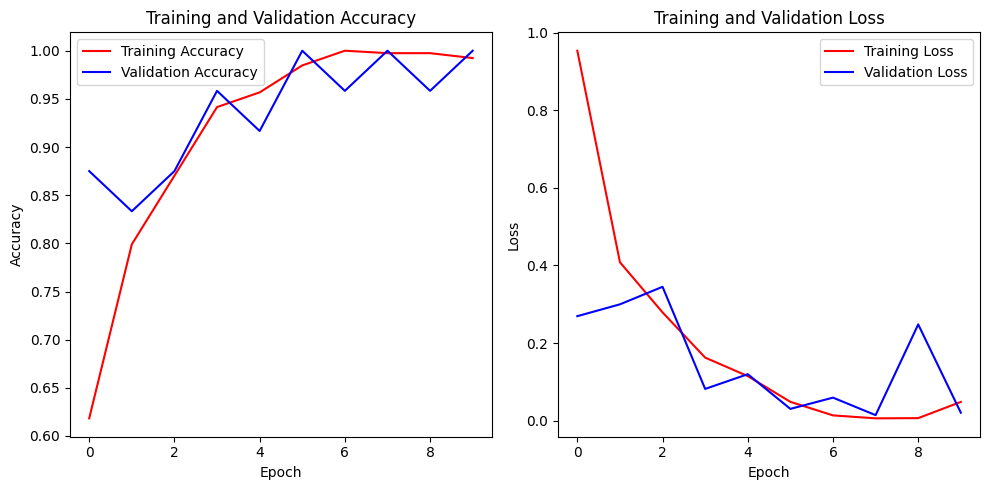

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### **Hasil Klasifikasi Menggunakan MobileNetV2 + SE Block + ViT Tail**

In [ ]:
# Fungsi untuk mengambil 5 gambar sampel dari dataset validasi
def get_sample_images(dataset, num_samples=5):
    sample_images = []
    sample_labels = []

    # Mengambil batch pertama dari dataset validasi
    for images, labels in dataset.take(1):
        for i in range(num_samples):
            sample_images.append(images[i].numpy())  # Menambahkan gambar ke list
            sample_labels.append(labels[i].numpy())  # Menambahkan label ke list

    return np.array(sample_images), np.array(sample_labels)

# Fungsi untuk mendekode label menjadi nama kelas yang bisa dibaca
def decode_label(label, class_indices):
    class_names = list(class_indices.keys())
    return class_names[label]

In [ ]:
# Ambil 10 gambar sampel dari dataset validasi
sample_images, sample_labels = get_sample_images(val_ds, num_samples=10)

In [ ]:
# Prediksi kelas menggunakan model yang telah dilatih
predictions = model.predict(sample_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
# Ambil indeks kelas dengan probabilitas tertinggi
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
# Pisahkan gambar berdasarkan prediksi
cataract_images = []
cataract_labels = []
normal_images = []
normal_labels = []

# Pisahkan gambar berdasarkan prediksi
for i in range(len(predicted_classes)):
    if predicted_classes[i] == 0:  # Asumsi 0 adalah label untuk "cataract"
        cataract_images.append(sample_images[i])
        cataract_labels.append(decode_label(predicted_classes[i], train_generator.class_indices))
    else:
        normal_images.append(sample_images[i])
        normal_labels.append(decode_label(predicted_classes[i], train_generator.class_indices))

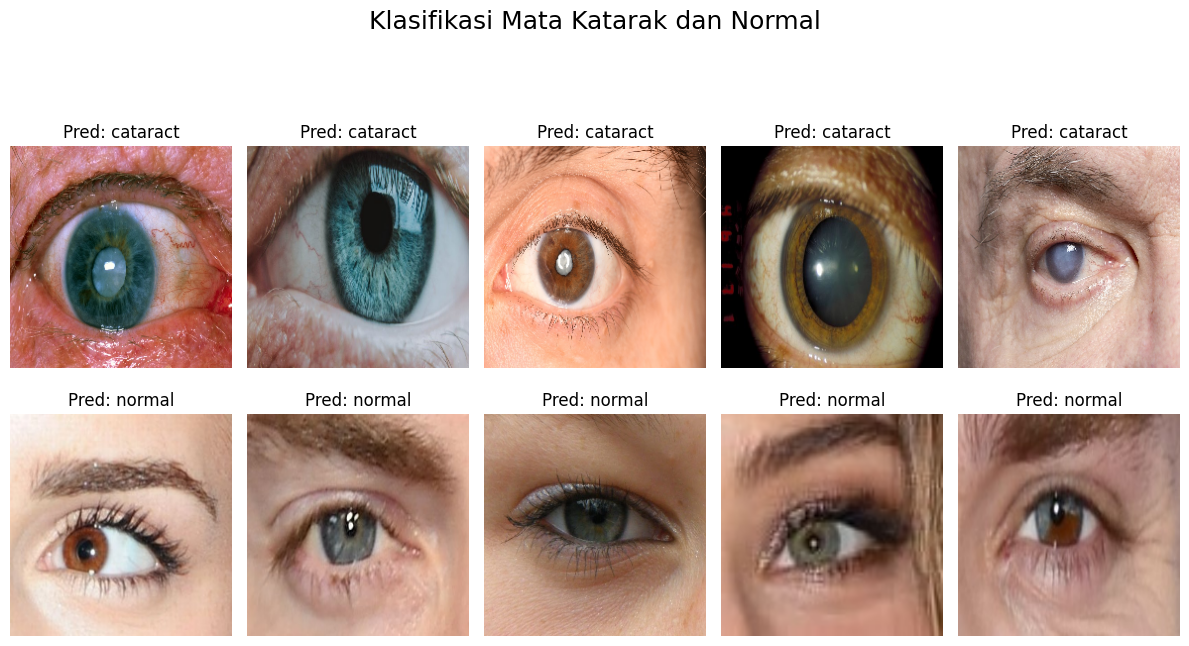

In [ ]:
# Pastikan hanya mengambil 5 gambar dari masing-masing kategori
cataract_images = cataract_images[:5]
normal_images = normal_images[:5]
cataract_labels = cataract_labels[:5]
normal_labels = normal_labels[:5]

# Menyusun subplot dengan dua baris dan lima kolom (total 10 gambar)
fig, axes = plt.subplots(2, 5, figsize=(12, 7))  # 2 baris, 5 kolom

# Menampilkan gambar katarak (baris pertama)
for i, ax in enumerate(axes[0, :len(cataract_images)]):  # Baris pertama untuk katarak
    ax.imshow(cataract_images[i].astype("uint8"))
    ax.set_title(f"Pred: {cataract_labels[i]}")
    ax.axis('off')  # Menghilangkan axis untuk tampilan gambar yang lebih rapi

# Menampilkan gambar normal (baris kedua)
for i, ax in enumerate(axes[1, :len(normal_images)]):  # Baris kedua untuk normal
    ax.imshow(normal_images[i].astype("uint8"))
    ax.set_title(f"Pred: {normal_labels[i]}")
    ax.axis('off')  # Menghilangkan axis untuk tampilan gambar yang lebih rapi

# Menambahkan judul untuk masing-masing kelompok gambar
plt.suptitle("Klasifikasi Mata Katarak dan Normal", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Memberikan ruang untuk judul utama
plt.show()